In [1]:
# Standard Python modules
import os, sys
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import textwrap

# import geopandas as gpd

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# extras
%matplotlib inline

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from ar_funcs import AR_rank

In [2]:
# Set up paths

path_to_data = '/home/dnash/SEAK_clim_data/'      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures


### Data from all notebooks (TODO: make yaml dict)

In [3]:
ext1 = [-141., -130., 54., 61.] # extent of SEAK 

## six communities
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.8894, 59.3988, Klukwan
# -139.671	59.5121, Yakutat (PAYA)
# -133.1358, 55.4769, Craig
# -132.4009, 55.5400, Kasaan

xs = [-135.4519, -135.3277, -135.8894, -139.671, -133.1358, -132.4009]
ys = [58.1122, 59.4538, 59.3988, 59.5121, 55.4769, 55.5400]
lbl1 = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
lbl1 = ['Hoonah', 'Skagway', 'Haines', 'Yakutat', 'Klawock', 'Ketchikan']
lbl_align = ['center', 'left', 'right', 'center', 'right', 'center'] # where the labels go

## closest station
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.5117	59.2429, Haines (PAHN)
# -139.671	59.5121, Yakutat (PAYA)
# -133.076	55.5792, Klawock (PAKW)
# -131.7117	55.3567, Ketchikan (PAKT)
xs2 = [-135.4519, -135.3277, -135.5117, -139.671, -133.076, -131.7117]
ys2 = [58.1122, 59.4538, 59.2429, 59.5121, 55.5792, 55.3567]
lbl2 = ['PAOH', 'PAGY', 'PAHN', 'PAYA', 'PAKW', 'PAKT']

### Read IVT data

In [4]:
datelst = ['1128', '1129', '1130', '1201', '1202', '1203']
filenames = []
for i, monthday in enumerate(datelst):
    filenames.append('/data/downloaded/Reanalysis/ERA5/IVT/2020/ERA5_IVT_2020{0}.nc'.format(monthday))
    
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(lat=slice(ext1[2], ext1[3]), lon=slice(ext1[0], ext1[1]))

era = xr.open_mfdataset(filenames, preprocess=preprocess, combine='by_coords')

# select the grid cell closest to each of the communities
df_lst = []
row_lbl = []
rank = []
for i, (slon, slat) in enumerate(zip(xs2, ys2)):
    ds = era.sel(lat=slat, lon=slon, method="nearest")
    df = ds.to_dataframe() # IVT magnitude
    df_lst.append(df)
    
    # calculate AR rank
    rank.append(AR_rank(df.IVT))
    
    # make nice labels for plot
    lbl = u"{:.2f}\N{DEGREE SIGN}N, {:.2f}\N{DEGREE SIGN}W".format(slat, slon*-1)
    row_lbl.append(lbl)

df_lst[0]

,IVT,lat,lon,uIVT,vIVT,IWV
time,,,,,,
2020-11-28 00:00:00,21.219994,58.0,-135.5,2.108398,21.114990,4.071617
2020-11-28 01:00:00,32.005680,58.0,-135.5,5.059326,31.603271,5.161693
2020-11-28 02:00:00,48.825709,58.0,-135.5,10.145508,47.760010,6.657910
2020-11-28 03:00:00,66.475656,58.0,-135.5,14.118896,64.958984,7.703196
2020-11-28 04:00:00,86.189076,58.0,-135.5,17.910400,84.307617,8.557195
...,...,...,...,...,...,...
2020-12-03 19:00:00,120.458302,58.0,-135.5,1.499023,120.448975,12.726094
2020-12-03 20:00:00,127.758430,58.0,-135.5,-5.842773,127.624756,13.185733
2020-12-03 21:00:00,125.423750,58.0,-135.5,-8.520020,125.134033,13.250397


### Read ASOS precipitation data

In [6]:
## location and name of txt file
filename = path_to_data + 'downloads/asos.csv'
df = pd.read_csv(filename, header=0, sep=',', engine='python',
                      parse_dates=['valid'])

# Converting the index as date (need to do this to utilize functionality of resample)
df.index = pd.to_datetime(df.valid)
stn_lst = df.station.unique()
# # list column names
# for col in df.columns:
#     print(col)

# p01i:
# one hour precip in inches
# for the period from the observation time to the time of the previous hourly precipitation reset

merge_df_lst = []
for i, stn in enumerate(stn_lst):    
    ## select single station
    idx = df['station'] == stn
    tmp = df[idx]

    ## convert from inches/hour to mm/hour
    tmp['p01i'] = tmp['p01i']*25.4

    ## resample to hourly precipitation
    precip_1hour = tmp['p01i'].resample('1H').max()

    tmp2 = precip_1hour.to_frame()
    tmp2 = tmp2.reset_index() # reset index to merge with IVT
    tmp2 = tmp2.rename(columns={"valid": "time"})
    
    tmp3 = df_lst[i].reset_index()
    
    merged_data = pd.merge(tmp3, tmp2, how='outer', on='time')
    # reset index to time
    merge_df_lst.append(merged_data)
    
merge_df_lst[1]

/home/dnash/miniconda3/envs/pyclivac/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,time,IVT,lat,lon,uIVT,vIVT,IWV,p01i
0,2020-11-28 00:00:00,18.405739,59.5,-135.25,2.889648,18.177490,3.030602,0.0
1,2020-11-28 01:00:00,17.355514,59.5,-135.25,2.559326,17.165771,2.804271,0.0
2,2020-11-28 02:00:00,19.263508,59.5,-135.25,4.239258,18.791260,2.859082,0.0
3,2020-11-28 03:00:00,26.075212,59.5,-135.25,7.650146,24.927734,3.308664,0.0
4,2020-11-28 04:00:00,37.801332,59.5,-135.25,12.566650,35.651367,4.002507,0.0
...,...,...,...,...,...,...,...,...
139,2020-12-03 19:00:00,101.195196,59.5,-135.25,51.561523,87.073975,6.702657,NaN
140,2020-12-03 20:00:00,101.125419,59.5,-135.25,48.532227,88.718506,7.168155,NaN
141,2020-12-03 21:00:00,96.963674,59.5,-135.25,45.542480,85.602783,7.469147,NaN
142,2020-12-03 22:00:00,95.920078,59.5,-135.25,38.883789,87.685303,7.942708,NaN


### Load IMERG-PM Data

ds size in GB 0.01

CPU times: user 5.79 s, sys: 491 ms, total: 6.28 s
Wall time: 16.6 s


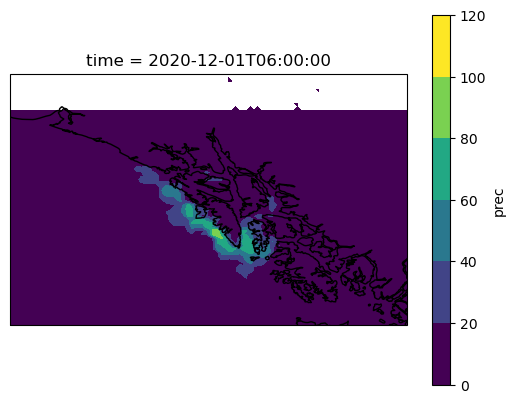

In [7]:
%%time
# List GPM filenames
fname_pattern = '/work/dnash/SEAK_clim_data/downloads/IMERG-PM/3B-HHR.MS*.nc4'

gpm = xr.open_mfdataset(fname_pattern, engine='netcdf4', concat_dim='time', combine='nested',
                           preprocess=preprocess)

print('ds size in GB {:0.2f}\n'.format(gpm.nbytes / 1e9))
gpm = gpm.transpose('lat', 'lon', 'time')
gpm = gpm.rename({'precipitationCal': 'prec'})
gpm = gpm.resample(time='1H').mean()
gpm = gpm.sel(time=slice('2020-11-28 01', '2020-12-03 23'))

# # fix time
# datetimeindex = gpm.indexes['time'].to_datetimeindex()
# gpm['time'] = datetimeindex
# print('ds size in GB {:0.2f}\n'.format(gpm.nbytes / 1e9))
# gpm = gpm.load()

## test plot 1 time step of daily data
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.PlateCarree())
test = gpm.sel(time='2020-12-01 06:00:00').prec
test
test.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

In [8]:
### pull precip time series from gpm data
diff_lat = gpm.lat.values[2] - gpm.lat.values[1]
diff_lon = gpm.lon.values[2] - gpm.lon.values[1]
# select the grid cell closest to each of the communities
df_lst2 = []
row_lbl2 = []
for i, (slon, slat) in enumerate(zip(xs2, ys2)):
    # select nearest grid cell to station
    ds = gpm.sel(lat=slat, lon=slon, method="nearest")
    df = ds.prec.to_dataframe()
    df_lst2.append(df)
    
    # ## TODO: select 9 nearest grid cells
    # ds = gpm.sel(lat=slice(slat-diff_lat*1.5, slat+diff_lat*1.5), lon=slice(slon-diff_lon*1.5, slon+diff_lon*1.5))
    # ds = ds.mean(("lon", "lat"))
    # df = ds.prec.to_dataframe()
    # df_lst2.append(df)
    
    # make nice labels for plot
    lbl = u"{:.2f}\N{DEGREE SIGN}N, {:.2f}\N{DEGREE SIGN}W".format(slat, slon*-1)
    row_lbl2.append(lbl)

In [9]:
df_lst2[0]

,lon,lat,prec
time,,,
2020-11-28 01:00:00,-135.449997,58.150002,0.001117
2020-11-28 02:00:00,-135.449997,58.150002,0.080469
2020-11-28 03:00:00,-135.449997,58.150002,0.179625
2020-11-28 04:00:00,-135.449997,58.150002,0.143302
2020-11-28 05:00:00,-135.449997,58.150002,0.000000
...,...,...,...
2020-12-03 19:00:00,-135.449997,58.150002,0.330171
2020-12-03 20:00:00,-135.449997,58.150002,0.471109
2020-12-03 21:00:00,-135.449997,58.150002,0.032430


In [10]:
## merge IVT, ASOS, and GPM data
merge_df_final = []
for i, (df1, df2) in enumerate(zip(merge_df_lst, df_lst2)):    
    
    tmp2 = df2.reset_index()
    tmp2 = tmp2.rename(columns={"lat": "gpmlat", "lon": "gpmlon"})
    
    
    merged_data = pd.merge(df1, tmp2, how='outer', on='time')
    merged_data.index = pd.to_datetime(merged_data.time)
    merge_df_final.append(merged_data)
    
merge_df_final[0]

,time,IVT,lat,lon,uIVT,vIVT,IWV,p01i,gpmlon,gpmlat,prec
time,,,,,,,,,,,
2020-11-28 00:00:00,2020-11-28 00:00:00,21.219994,58.0,-135.5,2.108398,21.114990,4.071617,2.032,NaN,NaN,NaN
2020-11-28 01:00:00,2020-11-28 01:00:00,32.005680,58.0,-135.5,5.059326,31.603271,5.161693,0.254,-135.449997,58.150002,0.001117
2020-11-28 02:00:00,2020-11-28 02:00:00,48.825709,58.0,-135.5,10.145508,47.760010,6.657910,0.508,-135.449997,58.150002,0.080469
2020-11-28 03:00:00,2020-11-28 03:00:00,66.475656,58.0,-135.5,14.118896,64.958984,7.703196,0.254,-135.449997,58.150002,0.179625
2020-11-28 04:00:00,2020-11-28 04:00:00,86.189076,58.0,-135.5,17.910400,84.307617,8.557195,1.778,-135.449997,58.150002,0.143302
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-03 19:00:00,2020-12-03 19:00:00,120.458302,58.0,-135.5,1.499023,120.448975,12.726094,NaN,-135.449997,58.150002,0.330171
2020-12-03 20:00:00,2020-12-03 20:00:00,127.758430,58.0,-135.5,-5.842773,127.624756,13.185733,NaN,-135.449997,58.150002,0.471109
2020-12-03 21:00:00,2020-12-03 21:00:00,125.423750,58.0,-135.5,-8.520020,125.134033,13.250397,NaN,-135.449997,58.150002,0.032430


### Plot time series

In [15]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

### Get x-tick and x-labels
x_ticks = merge_df_final[0].index.values

x_labels = []
for i, x in enumerate(x_ticks):
    t = pd.to_datetime(x_ticks[i])
    x_labels.append(t.strftime('%m-%d %H')+':00')


barb_dict = {'half': 50, 'full': 250, 'flag': 500}

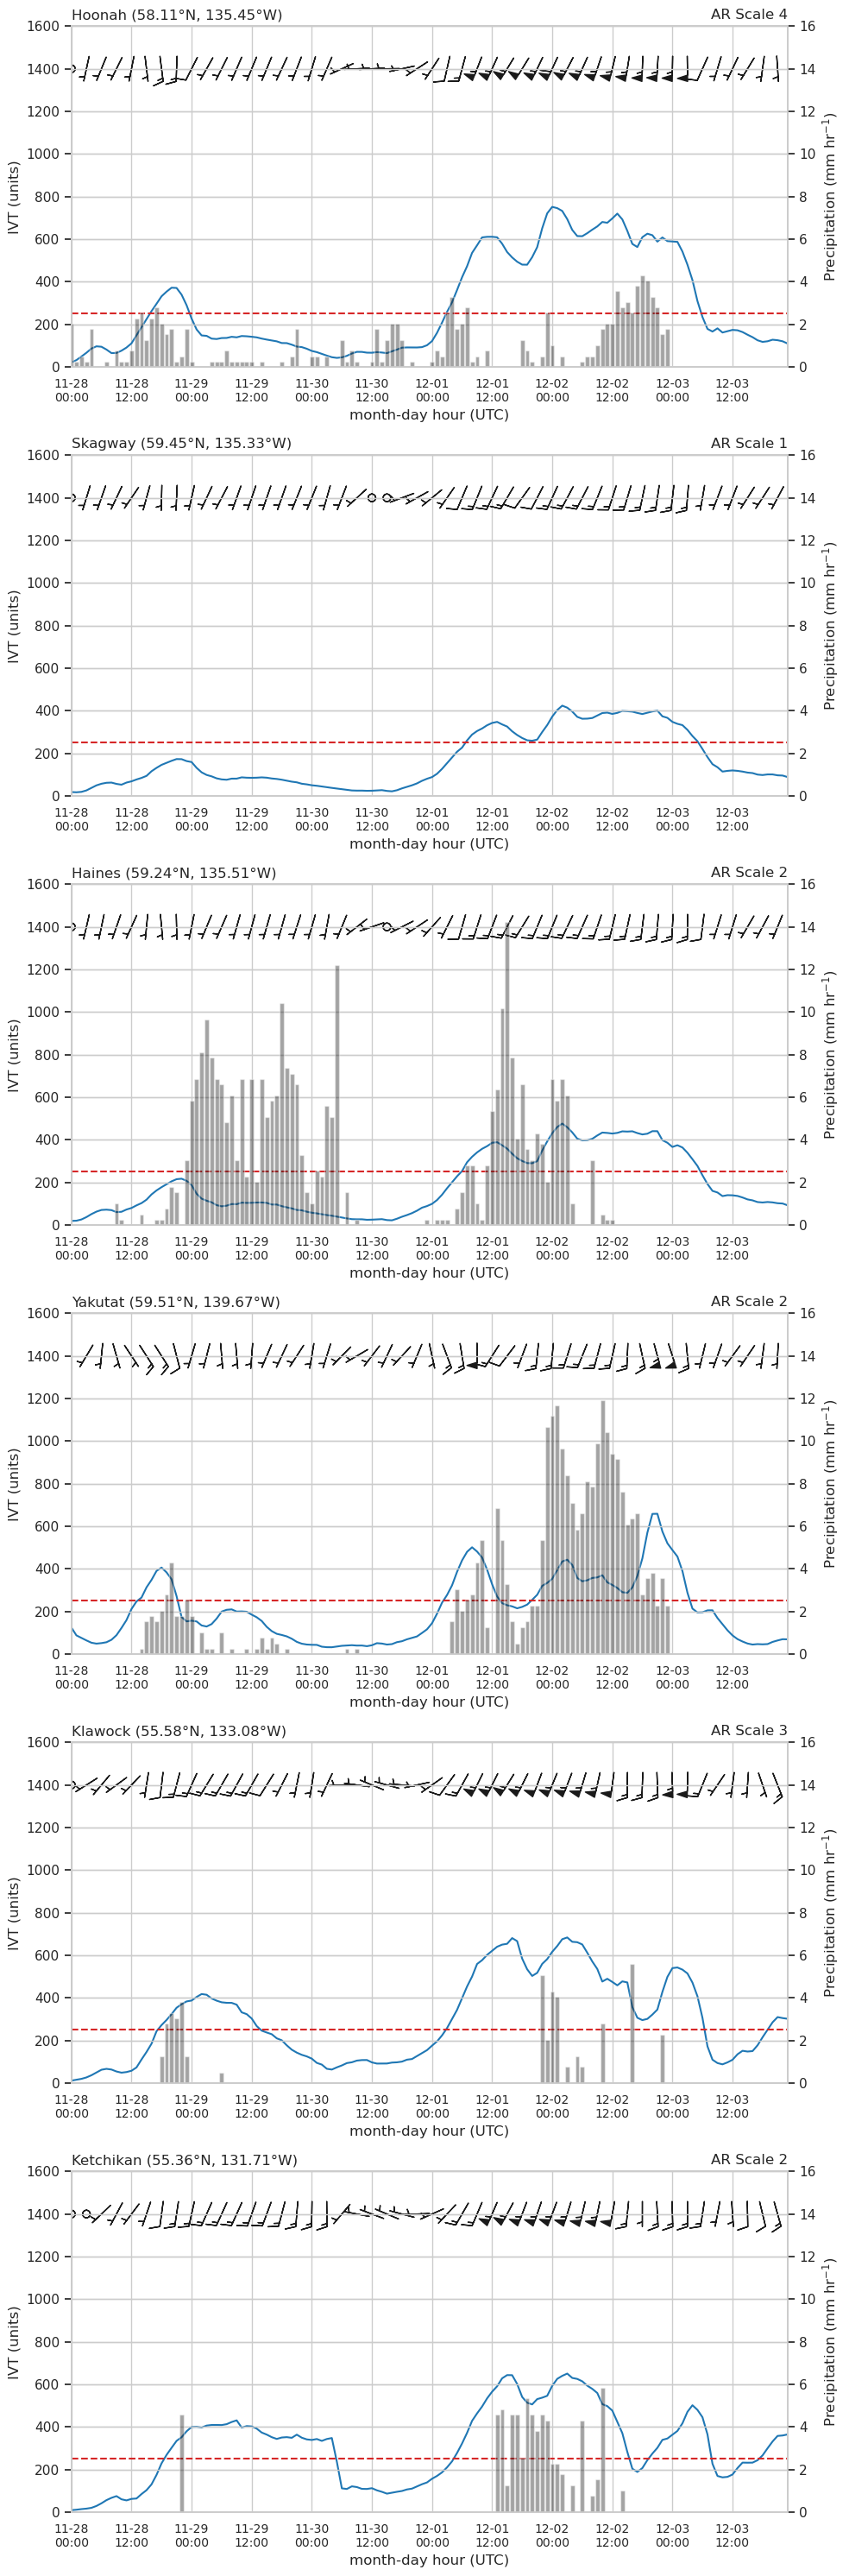

In [18]:
fname = path_to_figs + 'precip-IVT_time_series_dec2020'
fmt = 'png'
nrows = 6
ncols = 1
nplots=nrows*ncols

xaxis_lbl = ['']*4 + ['month-day hour (UTC)']*2
xaxis_lbl_all = 'month-day hour (UTC)'
ylbl = ['IVT (kg m$^{-1}$ s$^{-1}$)', '']*3
ylbl_all = 'IVT (units)'
ylbl2 = ['', 'Precipitation (mm hr$^{-1}$)']*3
ylbl2_all = 'Precipitation (mm hr$^{-1}$)'

fig = plt.figure(figsize=(10,30))
sns.set_style("whitegrid")

for i, (df, lbl) in enumerate(zip(merge_df_final, lbl1)):
    
    ax = fig.add_subplot(nrows, ncols, i+1)
    
    # plot IVT
    # ivt = sns.lineplot(x=df.index, y="IVT", data=df, color='tab:blue', ax=ax, label='IVT', legend=False)
    ivt = ax.plot(df.time, df.IVT, color='tab:blue', label='IVT')
    
    # add 250 kg m-1 s-1 threshold
    ax.axhline(y=250.0, color='tab:red', linestyle='--')
    
    # add IVT barbs
    uvec = df.uIVT
    vvec = df.vIVT
    Q = ax.barbs(df.time[::3], 1400, uvec[::3], vvec[::3], pivot='middle',
             barbcolor='k', length=6.5, barb_increments=barb_dict)

    
    # ax.set_ylabel(ylbl[i])
    ax.set_ylabel(ylbl_all)
    ax.set_ylim(0, 1600)

    ax.set_title(lbl+' ({0})'.format(row_lbl[i]), loc='left')
    ax.set_title('AR Scale {0}'.format(rank[i]), loc='right')
    
    ## x-axis format dates/ticks
    ax.set_xlim(df.index.min(), df.index.max())
    ax.set_xticks(x_ticks[::12]) # set the labels every 24 hours
    # ax.set_xticklabels(x_labels[::12], fontsize=10)
    ax.set_xticklabels([textwrap.fill(label, 5) for label in x_labels[::12]], fontsize=10)
    # ax.set_xlabel(xaxis_lbl[i])
    ax.set_xlabel(xaxis_lbl_all)
    
    
    ## add twin axis for precip info
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    # prec = sns.barplot(x=df.index, y="p01i", data=df, color='k', alpha=0.5, ax=ax2)
    prec = ax2.bar(x=df.index, height=df.p01i, width=0.035, color='k', alpha=0.4, align='center')
    # prec2 = ax2.bar(x=df.index, height=df.prec, width=0.035, color='tab:blue', alpha=0.5, align='center')
    # ax2.set_ylabel(ylbl2[i])
    ax2.set_ylabel(ylbl2_all)
    ax2.set_ylim(0, 16)
    
    ## x-axis format dates/ticks
    ax2.set_xlim(df.index.min(), df.index.max())
    ax2.set_xticks(x_ticks[::12]) # set the labels every 24 hours
    # ax2.set_xticklabels(x_labels[::12], fontsize=10)
    ax2.set_xticklabels([textwrap.fill(label, 5) for label in x_labels[::12]], fontsize=10)
    # ax2.set_xlabel(xaxis_lbl[i])
    ax2.set_xlabel(xaxis_lbl_all)
    


# Save the figure
fig.tight_layout()
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)

# Show
plt.show()


